In [45]:
import os
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# ETF list
etf_list = [
    'XLK', 'XLF', 'XLV', 'XLE', 'XLI', 'XLY', 'XLP', 'XLRE', 'XLU', 'XLB', 'XLC',
    'SOXX', 'SH', 'DOG', 'RWM', 'ITA', 'JETS'
]

# Date range: from 10 years ago to now
# Define the start of your 10-year weekly backtest period
today = datetime.today()
back_time = today - timedelta(weeks=52 * 10)

# Define start and end as strings for use in yfinance
start_date = back_time.strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')

print(f"📅 Downloading weekly data from {start_date} to {end_date}")

# Ensure dataset/ exists
dataset_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
if not os.path.isdir(dataset_path):
    raise FileNotFoundError(f"🚫 'dataset/' folder not found at {dataset_path}")

# Containers
adjclose_data, volume_data, high_data, low_data = {}, {}, {}, {}

# Download each ETF
for symbol in etf_list:
    print(f"⬇️ Downloading {symbol}...")
    data = yf.download(symbol, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        adjclose_data[symbol] = data[['Adj Close']].rename(columns={'Adj Close': symbol})
        volume_data[symbol] = data[['Volume']].rename(columns={'Volume': symbol})
        high_data[symbol] = data[['High']].rename(columns={'High': symbol})
        low_data[symbol] = data[['Low']].rename(columns={'Low': symbol})

# Merge and save
def combine_and_save(data_dict, filename):
    df = pd.concat(data_dict.values(), axis=1)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.index = pd.to_datetime(df.index, errors='coerce')
    df = df[~df.index.duplicated(keep='first')].sort_index()
    df.dropna(axis=0, how='all', inplace=True)
    path = os.path.join(dataset_path, filename)
    df.to_csv(path)
    print(f"✅ Saved: {filename}")
    return df

# Save all
price_df = combine_and_save(adjclose_data, 'etf_prices_weekly.csv')
volume_df = combine_and_save(volume_data, 'etf_volume_weekly.csv')
high_df = combine_and_save(high_data, 'etf_high_weekly.csv')
low_df = combine_and_save(low_data, 'etf_low_weekly.csv')

# Preview
price_df.head()


📅 Downloading weekly data from 2015-04-28 to 2025-04-15
⬇️ Downloading XLK...
⬇️ Downloading XLF...
⬇️ Downloading XLV...
⬇️ Downloading XLE...
⬇️ Downloading XLI...
⬇️ Downloading XLY...
⬇️ Downloading XLP...
⬇️ Downloading XLRE...
⬇️ Downloading XLU...
⬇️ Downloading XLB...
⬇️ Downloading XLC...
⬇️ Downloading SOXX...
⬇️ Downloading SH...
⬇️ Downloading DOG...
⬇️ Downloading RWM...
⬇️ Downloading ITA...
⬇️ Downloading JETS...
✅ Saved: etf_prices_weekly.csv
✅ Saved: etf_volume_weekly.csv
✅ Saved: etf_high_weekly.csv
✅ Saved: etf_low_weekly.csv


Price,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,XLB,XLC,SOXX,SH,DOG,RWM,ITA,JETS
Ticker,XLK,XLF,XLV,XLE,XLI,XLY,XLP,XLRE,XLU,XLB,XLC,SOXX,SH,DOG,RWM,ITA,JETS
Date,,,,,,,,,,,,,,,,,
2015-04-27,38.143692,16.326199,61.674625,55.324688,46.899544,68.204010,37.435749,NaN,32.086678,41.851208,NaN,28.564613,151.991379,79.626083,52.040852,54.522305,23.695282
2015-05-04,38.081753,16.607918,62.327995,54.583633,47.107689,68.427338,37.711845,NaN,31.769203,42.112534,NaN,28.441833,151.268295,78.749901,51.727150,54.787788,23.647640
2015-05-11,38.329548,16.567671,63.015366,53.855942,47.548950,68.418381,38.156693,NaN,31.978451,42.063530,NaN,28.762253,150.545212,78.259277,51.239155,55.656303,23.714336
2015-05-18,38.586193,16.674988,63.626343,53.542160,47.374107,68.731056,37.773212,NaN,32.158844,41.745052,NaN,29.208427,150.111359,78.329346,50.925446,55.633797,22.027941
2015-05-25,38.382652,16.500597,63.592377,52.333813,46.466602,68.159355,37.420410,NaN,32.108322,41.328587,NaN,30.265495,151.340607,79.205528,51.125866,54.702301,22.008884


In [46]:
import os 
import yfinance as yf
import pandas as pd
from datetime import datetime

# Macro indicator tickers on Yahoo Finance
macro_tickers = {
    'VIX': '^VIX',               # Volatility Index
    '10Y_Yield': '^TNX',         # 10-Year Treasury Yield (multiply by 0.1)
    'USD_Index': 'DX-Y.NYB',     # U.S. Dollar Index (ICE Dollar Index)
    'WTI_Crude': 'CL=F'          # Crude Oil (WTI Futures)
}

# Align with ETF backtest window using back_time
start_date = back_time.strftime('%Y-%m-%d')
end_date = datetime.today().strftime('%Y-%m-%d')

print(f"📊 Downloading macro data from {start_date} to {end_date}")

# Download weekly data
macro_data = {}
for name, ticker in macro_tickers.items():
    print(f"⬇️ Downloading {name} ({ticker})...")
    data = yf.download(ticker, start=start_date, end=end_date, interval='1wk', auto_adjust=False, progress=False)
    if not data.empty:
        macro_data[name] = data[['Close']].rename(columns={'Close': name})

# Combine all macro indicators into one DataFrame
macro_df = pd.concat(macro_data.values(), axis=1)

# Fix 10Y yield scale
if '10Y_Yield' in macro_df.columns:
    macro_df['10Y_Yield'] = macro_df['10Y_Yield'] * 0.1

# Clean and format
macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df.index = pd.to_datetime(macro_df.index)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df.sort_index(inplace=True)
macro_df.dropna(inplace=True)

# Save to CSV
macro_save_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))
macro_df.to_csv(macro_save_path)
print(f"✅ Macro indicators saved to: {macro_save_path}")

# Preview
macro_df.head()


📊 Downloading macro data from 2015-04-28 to 2025-04-15
⬇️ Downloading VIX (^VIX)...
⬇️ Downloading 10Y_Yield (^TNX)...
⬇️ Downloading USD_Index (DX-Y.NYB)...
⬇️ Downloading WTI_Crude (CL=F)...
✅ Macro indicators saved to: d:\CodingWorks\my_MLQT_project\Stock-Prediction-Models\dataset\macro_indicators_weekly.csv


Price,VIX,10Y_Yield,USD_Index,WTI_Crude
Ticker,^VIX,^TNX,DX-Y.NYB,CL=F
Date,,,,
2015-04-27,12.70,0.2117,95.300003,59.150002
2015-05-04,12.86,0.2150,94.790001,59.389999
2015-05-11,12.38,0.2141,93.139999,59.689999
2015-05-18,12.13,0.2215,96.010002,59.720001
2015-05-25,13.84,0.2095,96.910004,60.299999


In [14]:
import pandas as pd
import os
from ta import momentum, trend, volume

# === Paths ===
price_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_prices_weekly.csv'))
volume_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'etf_volume_weekly.csv'))

# === Helper to load ETF CSVs ===
def load_etf_csv(path, name='[unknown]'):
    try:
        header_row = pd.read_csv(path, header=None, nrows=2)
        columns = header_row.iloc[1].tolist()[1:]
        df = pd.read_csv(path, skiprows=3, header=None)
        df = df.iloc[:, :len(columns) + 1]
        df.columns = ['Date'] + columns
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.set_index('Date')
        df = df.apply(pd.to_numeric, errors='coerce')
        print(f"✅ Loaded {name} with {len(columns)} tickers")
        return df
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")
        raise

# === Load data ===
price_df = load_etf_csv(price_path, name='ETF Prices')
volume_df = load_etf_csv(volume_path, name='ETF Volume')

# === Feature storage ===
features_all = []
skipped = []

# === Feature generation loop ===
for symbol in price_df.columns:
    if symbol not in volume_df.columns:
        print(f"⚠️ Skipping {symbol}: volume data missing.")
        skipped.append(symbol)
        continue

    df = pd.DataFrame(index=price_df.index)
    df['close'] = price_df[symbol]
    df['volume'] = volume_df[symbol]

    try:
        # === Return-based technical indicators ===
        df[f'{symbol}_ret_1w'] = df['close'].pct_change(1)
        df[f'{symbol}_ret_3w'] = df['close'].pct_change(3)
        df[f'{symbol}_ret_6w'] = df['close'].pct_change(6)

        high = df['close'].rolling(window=14).max()
        low = df['close'].rolling(window=14).min()
        df[f'{symbol}_stoch_k'] = 100 * (df['close'] - low) / (high - low)
        df[f'{symbol}_stoch_d'] = df[f'{symbol}_stoch_k'].rolling(window=3).mean()
        df[f'{symbol}_williams_r'] = -100 * (high - df['close']) / (high - low)

        df[f'{symbol}_cci'] = trend.cci(high=df['close'], low=df['close'], close=df['close'], window=20)
        df[f'{symbol}_rsi'] = momentum.rsi(df['close'], window=14)
        df[f'{symbol}_obv'] = volume.on_balance_volume(df['close'], df['volume'])

        df[f'{symbol}_macd'] = trend.macd(df['close'])
        df[f'{symbol}_macd_signal'] = trend.macd_signal(df['close'])
        df[f'{symbol}_macd_diff'] = trend.macd_diff(df['close'])

        # === Add price and volume percent change (variation) ===
        df[f'{symbol}_price_change'] = df['close'].pct_change(1)
        df[f'{symbol}_volume_change'] = df['volume'].pct_change(1)

        derived_cols = df.columns.difference(['close', 'volume'])
        feature_df = df[derived_cols].copy()

        features_all.append(feature_df)
        print(f"📈 {symbol}: {feature_df.dropna(how='all').shape[0]} valid rows")

    except Exception as e:
        print(f"❌ Error processing {symbol}: {e}")
        skipped.append(symbol)

# === Final merge ===
if len(features_all) == 0:
    raise ValueError("🛑 No valid ETF features generated.")

features_df = pd.concat(features_all, axis=1).sort_index()
features_df = features_df[~features_df.index.duplicated(keep='first')]

print("📀 Final feature shape:", features_df.shape)

# === Save to CSV ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
features_df.to_csv(os.path.join(base_dir, 'weekly_etf_tech_feature.csv'))
print(f"✅ Saved features to: weekly_etf_tech_feature.csv")

✅ Loaded ETF Prices with 17 tickers
✅ Loaded ETF Volume with 17 tickers
📈 XLK: 521 valid rows
📈 XLF: 521 valid rows
📈 XLV: 521 valid rows
📈 XLE: 521 valid rows
📈 XLI: 521 valid rows
📈 XLY: 521 valid rows
📈 XLP: 521 valid rows
📈 XLRE: 508 valid rows
📈 XLU: 521 valid rows
📈 XLB: 521 valid rows
📈 XLC: 508 valid rows
📈 SOXX: 521 valid rows
📈 SH: 521 valid rows
📈 DOG: 521 valid rows
📈 RWM: 521 valid rows
📈 ITA: 521 valid rows
📈 JETS: 521 valid rows
📀 Final feature shape: (521, 238)
✅ Saved features to: weekly_etf_tech_feature.csv


In [20]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === Paths ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
feat_path = os.path.join(base_dir, 'weekly_etf_tech_feature.csv')
macro_path = os.path.join(base_dir, 'macro_indicators_weekly.csv')
price_path = os.path.join(base_dir, 'etf_prices_weekly.csv')
volume_path = os.path.join(base_dir, 'etf_volume_weekly.csv')

# === Load main features ===
feat_df = pd.read_csv(feat_path, index_col=0, parse_dates=True)

# === Load and parse macro indicators ===
macro_raw = pd.read_csv(macro_path, header=None)
macro_start = macro_raw.index[macro_raw[0] == 'Price'].tolist()[0]
macro_cols = macro_raw.iloc[macro_start].tolist()
macro_df = pd.read_csv(macro_path, skiprows=macro_start + 1, header=None)
macro_df.columns = macro_cols
macro_df['Price'] = pd.to_datetime(macro_df['Price'], errors='coerce')  # 'Price' is actually the 'Date'
macro_df = macro_df.rename(columns={'Price': 'Date'}).set_index('Date')
macro_df = macro_df.apply(pd.to_numeric, errors='coerce')
macro_df = macro_df[~macro_df.index.duplicated()].sort_index()

# === Load ETF price and volume ===
ticker_row = pd.read_csv(price_path, header=None, nrows=2).iloc[1, 1:].tolist()
price_df = pd.read_csv(price_path, skiprows=3, header=None)
volume_df = pd.read_csv(volume_path, skiprows=3, header=None)

price_df = price_df.iloc[:, :len(ticker_row)+1]
price_df.columns = ['Date'] + ticker_row
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df = price_df.set_index('Date').apply(pd.to_numeric, errors='coerce')

volume_df = volume_df.iloc[:, :len(ticker_row)+1]
volume_df.columns = ['Date'] + ticker_row
volume_df['Date'] = pd.to_datetime(volume_df['Date'])
volume_df = volume_df.set_index('Date').apply(pd.to_numeric, errors='coerce')

# === Output Directory ===
norm_dir = os.path.join(base_dir, 'normalized_matrix')
os.makedirs(norm_dir, exist_ok=True)

# === Normalize & Save per ETF ===
scaler = StandardScaler()

for ticker in ticker_row:
    feat_cols = [col for col in feat_df.columns if col.startswith(f'{ticker}_')]
    if len(feat_cols) == 0:
        print(f"⚠️ No features found for {ticker}, skipping...")
        continue

    df = feat_df[feat_cols].copy()
    df.columns = [col.replace(f'{ticker}_', '') for col in df.columns]

    df['price'] = price_df[ticker].pct_change()
    df['volume'] = volume_df[ticker].pct_change()

    # === Merge with true macro indicators ===
    df = df.join(macro_df, how='left')

    # === Build missing mask BEFORE filling
    mask = df.isna().astype(float)

    # === Fill and normalize only technical + pct change features, not macro
    macro_cols = macro_df.columns
    norm_cols = df.columns.difference(macro_cols)
    df[norm_cols] = scaler.fit_transform(df[norm_cols].fillna(0.0))
    df[macro_cols] = df[macro_cols].fillna(0.0)  # keep raw values for macro features

    # === Save
    df.to_csv(os.path.join(norm_dir, f'{ticker}_combined.csv'))
    mask.to_csv(os.path.join(norm_dir, f'{ticker}_mask.csv'))
    print(f"✅ Saved {ticker}: {df.shape[0]} rows, {df.shape[1]} features")


C:\Users\user\AppData\Local\Temp\ipykernel_31700\2028834899.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro_df['Price'] = pd.to_datetime(macro_df['Price'], errors='coerce')  # 'Price' is actually the 'Date'


✅ Saved XLK: 521 rows, 20 features
✅ Saved XLF: 521 rows, 20 features
✅ Saved XLV: 521 rows, 20 features
✅ Saved XLE: 521 rows, 20 features
✅ Saved XLI: 521 rows, 20 features
✅ Saved XLY: 521 rows, 20 features
✅ Saved XLP: 521 rows, 20 features
✅ Saved XLRE: 521 rows, 20 features
✅ Saved XLU: 521 rows, 20 features
✅ Saved XLB: 521 rows, 20 features
✅ Saved XLC: 521 rows, 20 features
✅ Saved SOXX: 521 rows, 20 features
✅ Saved SH: 521 rows, 20 features
✅ Saved DOG: 521 rows, 20 features
✅ Saved RWM: 521 rows, 20 features
✅ Saved ITA: 521 rows, 20 features
✅ Saved JETS: 521 rows, 20 features


# start training

In [11]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# === Paths ===
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
norm_dir = os.path.join(base_dir, 'normalized_matrix')
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
os.makedirs(model_dir, exist_ok=True)

# === Constants ===
ETF_LIST = [f.split('_')[0] for f in os.listdir(norm_dir) if f.endswith('_feature.csv')]
ETF_LIST = sorted(list(set(ETF_LIST)))

# === Custom Dataset ===
class ETFSequenceDataset(Dataset):
    def __init__(self, etf_list, window_size=10):
        self.data = []
        self.targets = []
        self.etf_names = []
        self.window_size = window_size

        for etf in etf_list:
            feat_path = os.path.join(norm_dir, f"{etf}_feature.csv")
            mask_path = os.path.join(norm_dir, f"{etf}_mask.csv")

            df = pd.read_csv(feat_path, index_col=0, parse_dates=True)
            mask = pd.read_csv(mask_path, index_col=0, parse_dates=True)

            if df.shape[0] < window_size + 1:
                continue

            for i in range(len(df) - window_size - 1):
                window_x = df.iloc[i:i+window_size].values.astype('float32')
                window_m = mask.iloc[i:i+window_size].values.astype('float32')
                y = df.iloc[i + window_size]['ret_1w']

                self.data.append((window_x, window_m))
                self.targets.append(y)
                self.etf_names.append(etf)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, m = self.data[idx]
        y = self.targets[idx]
        return torch.tensor(x), torch.tensor(m), torch.tensor(y), self.etf_names[idx]

# === Dual Transformer Model ===
class DualTransformerModel(nn.Module):
    def __init__(self, num_features, hidden_dim=64, nhead=4, num_layers=2, num_etfs=17):
        super().__init__()
        self.time_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=num_features, nhead=nhead, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.output_heads = nn.ModuleDict({etf: nn.Linear(num_features, 1) for etf in ETF_LIST})

    def forward(self, x_seq, etf_name):
        x_seq = x_seq.permute(1, 0, 2)  # [T, B, F]
        time_out = self.time_encoder(x_seq)
        time_out = time_out.permute(1, 0, 2)  # [B, T, F]
        etf_repr = time_out[:, -1, :]  # [B, F]
        out = self.output_heads[etf_name](etf_repr).squeeze()
        return out

# === Save model utility ===
def save_model(model, path):
    torch.save(model.state_dict(), path)

# === Load model utility ===
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# === Training Function ===
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=500):
    model.train()
    log = []
    best_weights = []

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_mae = []
        epoch_win = []

        for x, m, y, etf in dataloader:
            x, m, y = x.to(torch.float32), m.to(torch.float32), y.to(torch.float32)
            preds = torch.stack([model(x[i].unsqueeze(0), etf[i]) for i in range(len(etf))])
            loss = loss_fn(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds_np = preds.detach().numpy()
            y_np = y.numpy()
            epoch_losses.append(loss.item())
            epoch_mae.append(np.mean(np.abs(preds_np - y_np)))
            epoch_win.append(np.mean(np.sign(preds_np) == np.sign(y_np)))

        avg_loss = np.mean(epoch_losses)
        avg_mae = np.mean(epoch_mae)
        avg_win = np.mean(epoch_win)
        reward = avg_win * 0.6 + (1 - avg_mae) * 0.4
        log.append([epoch, avg_win, avg_mae, reward])
        best_weights.append((reward, model.state_dict()))
        best_weights = sorted(best_weights, key=lambda x: -x[0])[:5]

    log_df = pd.DataFrame(log, columns=['epoch', 'win_rate', 'mae', 'reward'])
    log_df.to_csv(os.path.join(model_dir, 'training_log_transformer.csv'), index=False)

    for i, (reward, state_dict) in enumerate(best_weights):
        torch.save(state_dict, os.path.join(model_dir, f'transformer_top{i+1}.pt'))


# === Now Begin Training Loop ===

# Setup
window_size = 10
batch_size = 32
num_epochs = 500
lr = 0.001

dataset = ETFSequenceDataset(ETF_LIST, window_size=window_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

sample_input = next(iter(dataloader))[0]  # (batch, T, F)
num_features = sample_input.shape[-1]

model = DualTransformerModel(num_features=num_features, hidden_dim=128, nhead=4, num_layers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

train_model(model, dataloader, optimizer, loss_fn, num_epochs=num_epochs)

AssertionError: embed_dim must be divisible by num_heads

C:\Users\user\AppData\Local\Temp\ipykernel_33048\765839658.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
c:\Users\user\anaconda3\envs\stock_pred\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


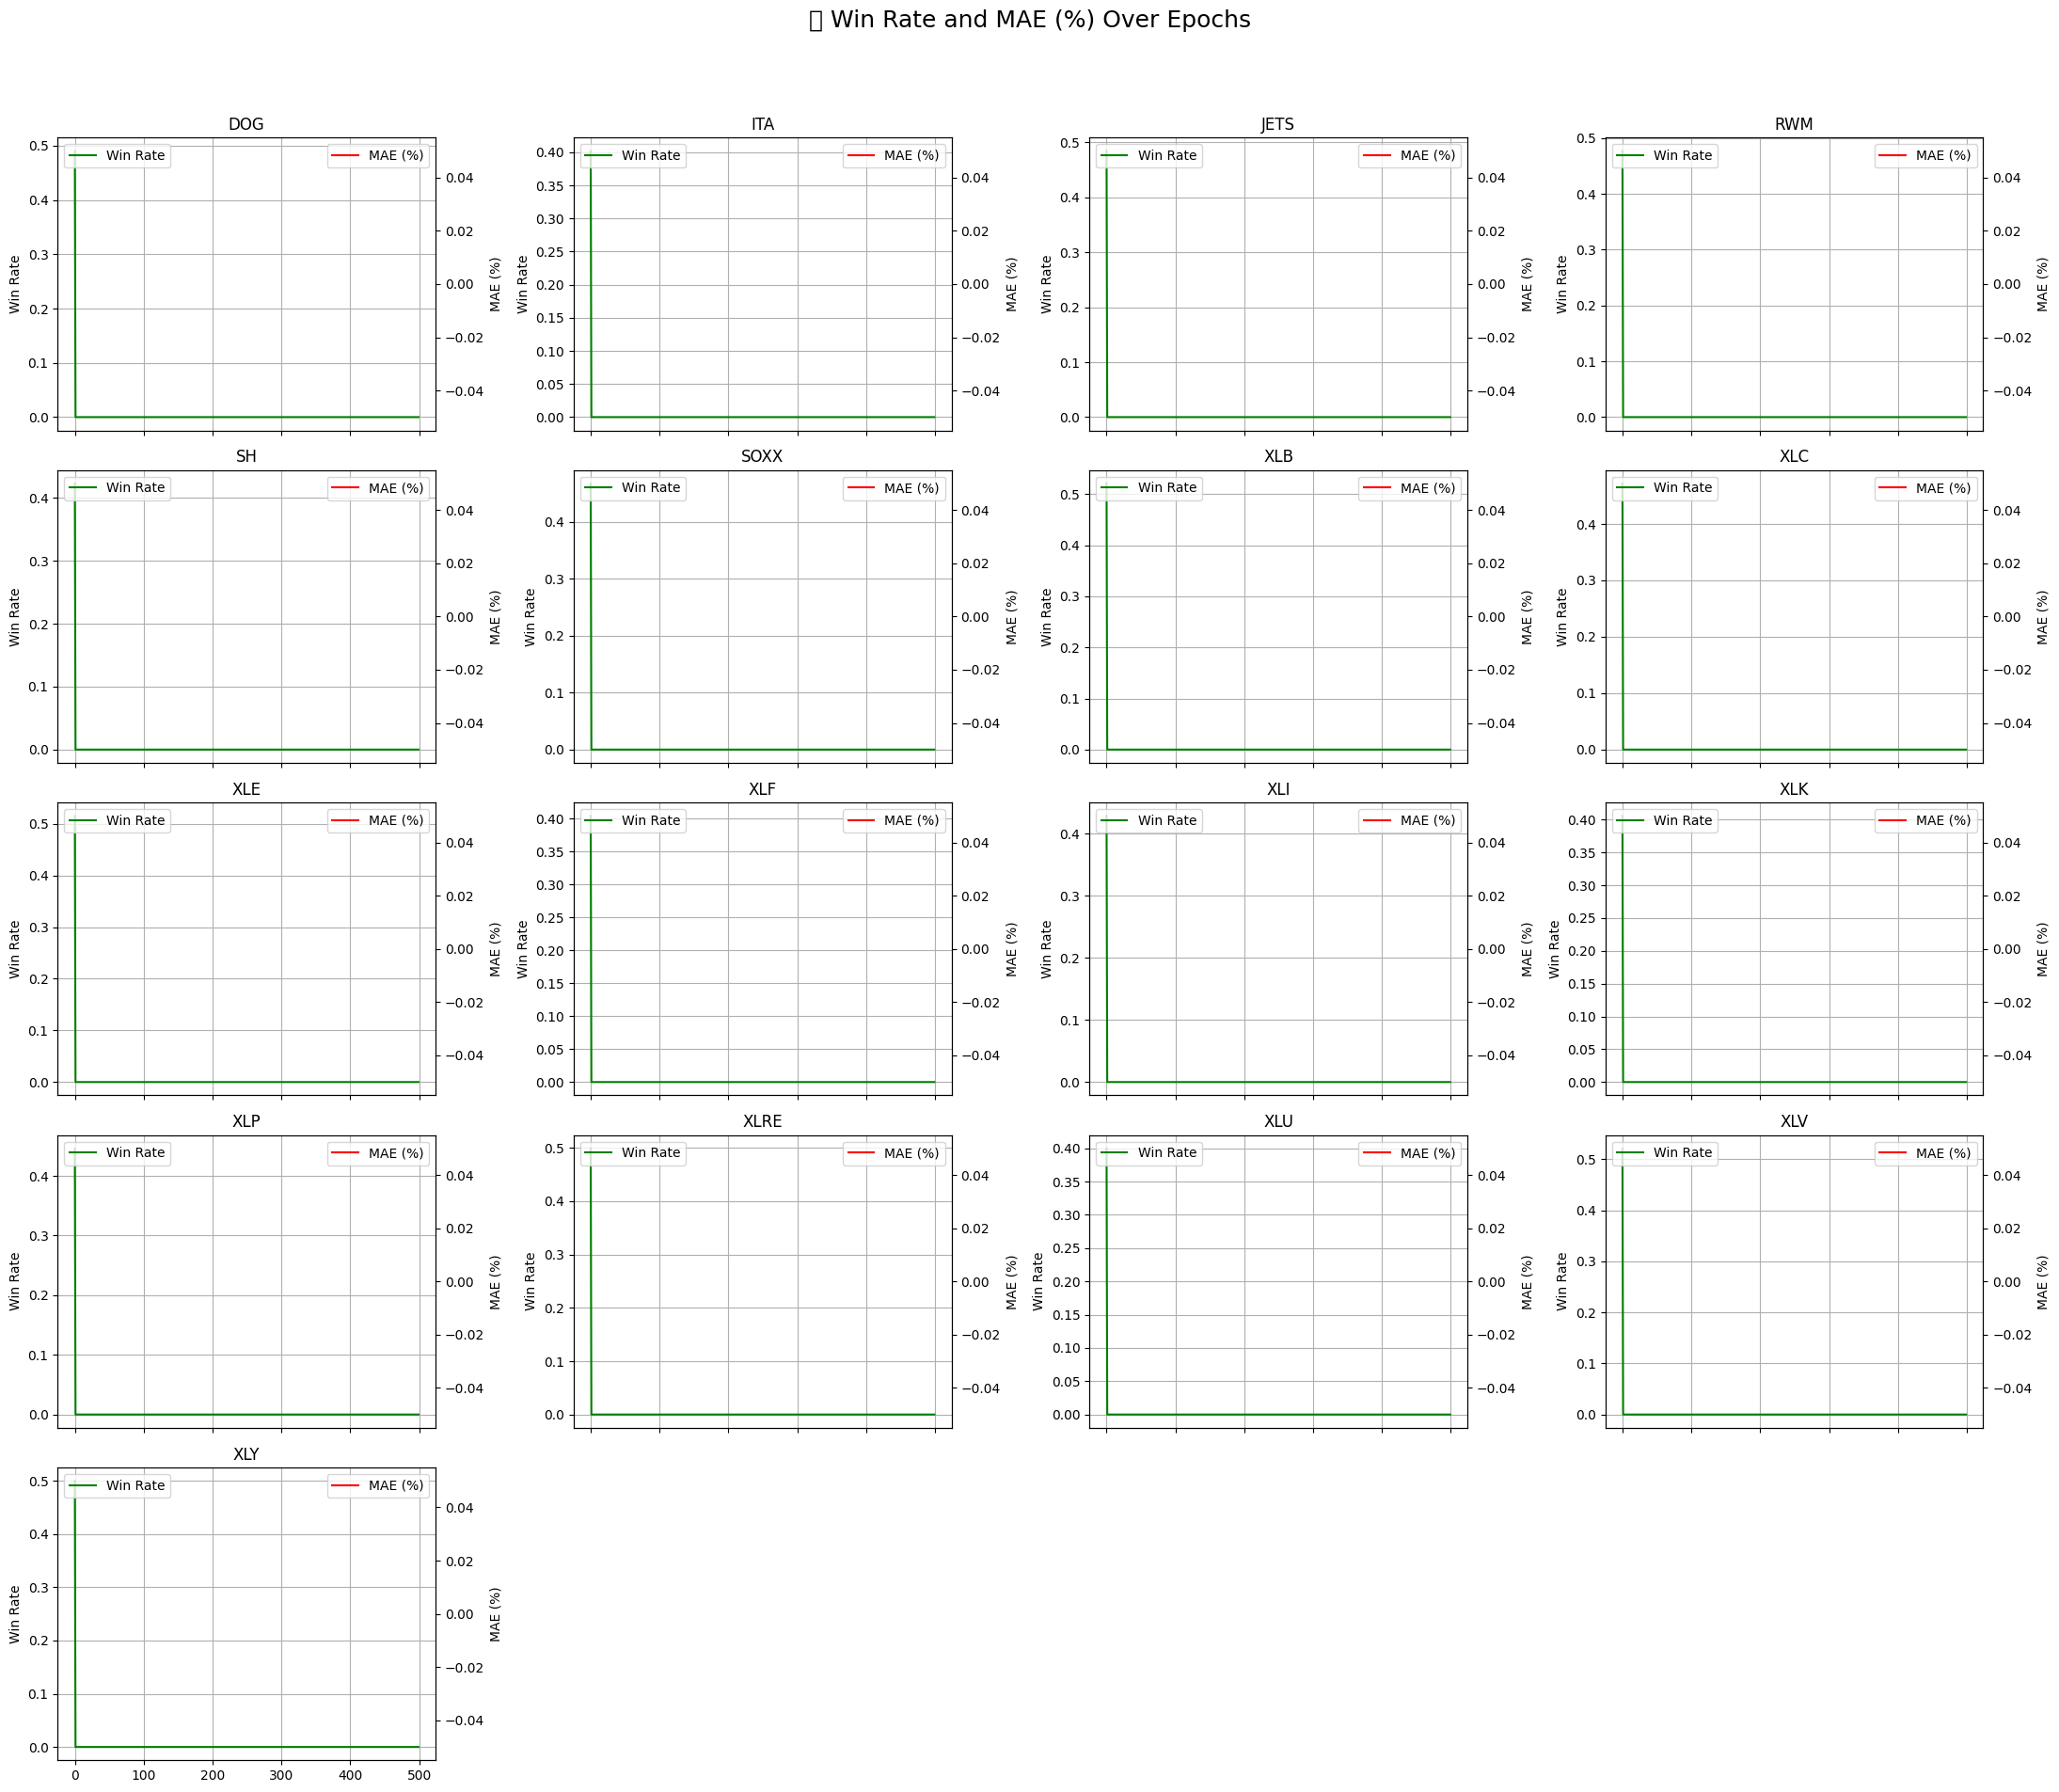

📊 Summary (Top 5 Epochs by Win Rate per ETF):
 ETF avg_win_rate_top5 avg_mae_top5 (%) top1_win_rate
 XLB            0.1042             nan%        0.5212
 XLV            0.1042             nan%        0.5212
 XLE            0.1031             nan%        0.5154
 XLY            0.1000             nan%        0.5000
XLRE            0.0998             nan%        0.4990
 DOG            0.0981             nan%        0.4904
JETS            0.0969             nan%        0.4846
 RWM            0.0954             nan%        0.4769
 XLC            0.0944             nan%        0.4719
SOXX            0.0935             nan%        0.4673
 XLP            0.0892             nan%        0.4462
 XLI            0.0858             nan%        0.4288
  SH            0.0846             nan%        0.4231
 XLK            0.0812             nan%        0.4058
 XLF            0.0808             nan%        0.4038
 ITA            0.0804             nan%        0.4019
 XLU            0.0800             n

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Folder where logs are saved ===
log_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
log_files = [f for f in os.listdir(log_dir) if f.startswith('training_log_') and f.endswith('.csv')]

# === Load logs and compute stats ===
etf_logs = {}
summary_stats = []

for file in log_files:
    etf = file.replace('training_log_', '').replace('.csv', '')
    df = pd.read_csv(os.path.join(log_dir, file))
    df['ETF'] = etf

    top5 = df.sort_values('win_rate', ascending=False).head(5)
    top1 = top5.iloc[0]

    summary_stats.append({
        'ETF': etf,
        'avg_win_rate_top5': top5['win_rate'].mean(),
        'avg_mae_top5_percent': top5['mae'].mean() * 100,  # convert to percent
        'top1_win_rate': top1['win_rate']
    })

    etf_logs[etf] = df

summary_df = pd.DataFrame(summary_stats)
summary_df = summary_df.sort_values('avg_win_rate_top5', ascending=False)

# === Format MAE as % string ===
summary_df['avg_mae_top5_percent'] = summary_df['avg_mae_top5_percent'].map(lambda x: f"{x:.2f}%")
summary_df['avg_win_rate_top5'] = summary_df['avg_win_rate_top5'].map(lambda x: f"{x:.4f}")
summary_df['top1_win_rate'] = summary_df['top1_win_rate'].map(lambda x: f"{x:.4f}")

# === Plotting: Win Rate vs. MAE with dual axes ===
cols = 4
rows = (len(etf_logs) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(22, 4 * rows), sharex=True)
axes = axes.flatten()

for i, (etf, df) in enumerate(sorted(etf_logs.items())):
    ax = axes[i]
    ax2 = ax.twinx()
    ax.plot(df['epoch'], df['win_rate'], label='Win Rate', color='green')
    ax2.plot(df['epoch'], df['mae'] * 100, label='MAE (%)', color='red')
    ax.set_title(etf)
    ax.set_ylabel('Win Rate')
    ax2.set_ylabel('MAE (%)')
    ax.grid(True)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('📈 Win Rate and MAE (%) Over Epochs', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# === Clean summary display ===
print("📊 Summary (Top 5 Epochs by Win Rate per ETF):")
print(summary_df.rename(columns={'avg_mae_top5_percent': 'avg_mae_top5 (%)'}).to_string(index=False))


In [50]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths
model_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'model_weights'))
tech_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'weekly_etf_tech_feature.csv'))
macro_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'macro_indicators_weekly.csv'))

# === Load features
tech_df = pd.read_csv(tech_path, index_col=0)
macro_df = pd.read_csv(macro_path)
macro_df.rename(columns={macro_df.columns[0]: 'Date'}, inplace=True)
macro_df = macro_df[~macro_df['Date'].astype(str).str.contains('Ticker', na=False)]
macro_features = macro_df.columns[1:].tolist()

# === Utility: simplify feature names
def simplify_feature(col, etf):
    if col.startswith(etf + "_"):
        return col[len(etf) + 1:]  # strip ETF_
    else:
        return col

# === Build ETF → {feature_type: avg_weight}
importance_table = {}
all_simplified = set()

for file in os.listdir(model_dir):
    if not file.endswith('_top1.pt'):
        continue

    etf = file.replace('_top1.pt', '')
    etf_features = [col for col in tech_df.columns if col.startswith(etf)]
    all_features = etf_features + macro_features
    simplified_names = [simplify_feature(f, etf) for f in all_features]
    input_dim = len(all_features)

    weights = []
    weight_sum = 0

    for i in range(1, 6):
        path = os.path.join(model_dir, f"{etf}_top{i}.pt")
        if not os.path.exists(path): continue

        ckpt = torch.load(path, map_location='cpu')
        state_dict = ckpt['weights']
        w = ckpt.get('weight', 1.0)

        first_layer = state_dict['model.0.weight'].numpy()
        importance = np.mean(np.abs(first_layer), axis=0)

        if len(importance) != input_dim:
            print(f"⚠️ {etf} shape mismatch: got {len(importance)} vs expected {input_dim}")
            break

        weights.append(importance * w)
        weight_sum += w

    if weights and len(weights) == 5:
        avg_importance = np.sum(weights, axis=0) / weight_sum
        importance_table[etf] = dict(zip(simplified_names, avg_importance))
        all_simplified.update(simplified_names)

# === Final table: ETF × feature type
sorted_features = sorted(all_simplified)
importance_df = pd.DataFrame(index=importance_table.keys(), columns=sorted_features)

for etf, feat_dict in importance_table.items():
    for feat, val in feat_dict.items():
        importance_df.loc[etf, feat] = val

importance_df = importance_df.fillna(0.0).astype(float)

# === Heatmap: Blue → Red color
plt.figure(figsize=(18, 7))
sns.heatmap(importance_df, cmap="coolwarm", linewidths=0.5)
plt.title("🔥 Feature Importance Heatmap (Top 5 Avg Weights, Simplified)", fontsize=16)
plt.xlabel("Feature Type")
plt.ylabel("ETF")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_33048\3743958291.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location='cpu')


KeyError: 'model.0.weight'

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "N/A")


CUDA available: True
CUDA version: 11.8
Device count: 1
Device name: NVIDIA GeForce RTX 3080
